In [37]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.callbacks import History
from tensorflow.keras import regularizers
import tensorflow
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import numpy as np
import pandas as pd
import glob
import random

# GCN

In [6]:
class GCNLayer(nn.Module):

    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out)

    def forward(self, node_feats, adj_matrix):
        """
        Inputs:
            node_feats - Tensor with node features of shape [batch_size, num_nodes, c_in]
            adj_matrix - Batch of adjacency matrices of the graph. If there is an edge from i to j, adj_matrix[b,i,j]=1 else 0.
                         Supports directed edges by non-symmetric matrices. Assumes to already have added the identity connections.
                         Shape: [batch_size, num_nodes, num_nodes]
        """
        # Num neighbours = number of incoming edges
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
        node_feats = self.projection(node_feats)
        node_feats = torch.bmm(adj_matrix, node_feats)
        node_feats = node_feats / num_neighbours
        return node_feats

In [7]:
folder_path='C:\\Users\\ASUS\\Desktop\\Courses-IITM\\ch5650\\Project\\Data'
file_list = glob.glob(folder_path + "\\*.csv")


In [8]:
adj_path='C:\\Users\\ASUS\\Desktop\\Courses-IITM\\ch5650\\Project\\Data\\Adj'
adj_list=glob.glob(adj_path + "\\*.csv")


# Implementation of GCN with a pooling layer

In [9]:
i=0
out_list=[]
while i<len(file_list):
    node=pd.read_csv(file_list[i])
    node_feats = torch.Tensor(np.array(node)).view(1,np.shape(node)[0],np.shape(node)[1])
    adj=pd.read_csv(adj_list[i],header=None)
    adj_matrix = torch.Tensor(np.array(adj)).view(1,np.shape(adj)[0],np.shape(adj)[1])
        
    layer = GCNLayer(c_in=np.shape(node)[1], c_out=1)
    layer.projection.weight.data = torch.eye(np.shape(node)[0],np.shape(node)[1])
    layer.projection.bias.data = torch.Tensor(np.array(np.zeros(np.shape(adj[0]))))

    with torch.no_grad():
        out_feats = layer(node_feats, adj_matrix)
        
    conv_layer = nn.MaxPool1d((np.shape(adj)[0]-1), stride=2)
    req_data = out_feats
    output = conv_layer(req_data)
    out_list.append(np.array(output.view(1,1,output.shape[1])))
    i=i+1
      

# Processing for creating the final dataset

In [10]:
for i in range(0,len(out_list)):
    out_list[i]=(np.reshape(np.array(out_list[i]),(1,len(out_list[i][0][0]))))
    

In [11]:
main_dataframe = pd.DataFrame(out_list[0])

for i in range(1,len(out_list)):
    data = pd.DataFrame(out_list[i])
    main_dataframe = pd.concat([main_dataframe,data],axis=0)


In [12]:
main_dataframe=main_dataframe.fillna(0)


In [13]:
main_dataframe=main_dataframe.reset_index(drop=True)

In [14]:
pid=[]
for i in range(0,len(file_list)):
    pid.append(file_list[i][55:62])
pid_data=pd.DataFrame(np.array(pid))
pid_data.columns=["PID"]

In [15]:
main_data=pd.concat([main_dataframe,pid_data],axis=1)

In [16]:
target_data=pd.read_csv("C:\\Users\\ASUS\\Desktop\\Courses-IITM\\ch5650\\Polymer_data\\target.csv")

In [17]:
data=pd.merge(main_data,target_data,how='inner')

In [18]:
data=data.drop(['Density'],axis=1)

# Distribution of Tg and Tm

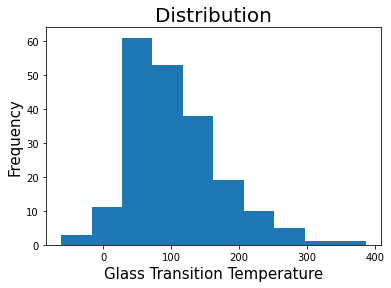

In [20]:
plt.hist(np.array(data.iloc[:,57]))
plt.xlabel('Glass Transition Temperature',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Distribution',fontsize=20)
plt.show()

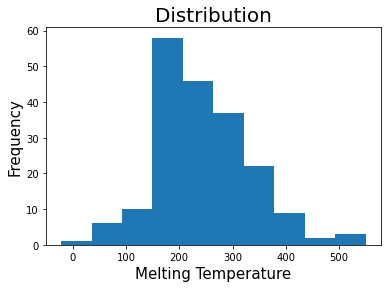

In [22]:
plt.hist(np.array(data.iloc[:,58]))
plt.xlabel('Melting Temperature',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Distribution',fontsize=20)
plt.show()

In [23]:
data_tg=data.dropna(subset=['Tg'])


In [28]:
data_tm=data.dropna(subset=['Tm '])

In [30]:
print(data_tg.shape)
print(data_tm.shape)

(202, 59)
(194, 59)


# For Glass Transition Temperature


In [71]:
x=data_tg.iloc[:,0:56].values
y=data_tg.iloc[:,57].values

In [72]:
le=LabelEncoder()
for i in range(0,56):
    x[:,i]=le.fit_transform(x[:,i])
    

In [73]:
random.seed(1)
X_train,X_test,Y_train,Y_test=train_test_split(x,y,test_size=0.8,random_state=0)

In [74]:
model= Sequential()
model.add(Dense(500,activation='relu',kernel_regularizer=regularizers.L1L2(l1=1e-2, l2=1e-2)))
model.add(Dropout(0.2))
model.add(Dense(400,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(300,activation='relu'))
model.add(Dense(200,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100,activation='relu'))
model.add(Dense(1,activation='linear'))


In [75]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_squared_error'])
history1=model.fit(X_train,Y_train,epochs=800,batch_size=3,verbose=1,
                    validation_data=(X_test, Y_test))

Epoch 1/800
14/14 [==============================] - 0s 15ms/step - loss: 7972.1226 - mean_squared_error: 7957.4756 - val_loss: 8895.2559 - val_mean_squared_error: 8881.5850
Epoch 2/800
14/14 [==============================] - 0s 7ms/step - loss: 4939.1089 - mean_squared_error: 4926.1416 - val_loss: 6038.0518 - val_mean_squared_error: 6025.8779
Epoch 3/800
14/14 [==============================] - 0s 6ms/step - loss: 3290.9851 - mean_squared_error: 3279.3286 - val_loss: 4851.0874 - val_mean_squared_error: 4840.0405
Epoch 4/800
14/14 [==============================] - 0s 7ms/step - loss: 3036.1511 - mean_squared_error: 3025.5076 - val_loss: 5173.2041 - val_mean_squared_error: 5163.0200
Epoch 5/800
14/14 [==============================] - 0s 7ms/step - loss: 2672.2227 - mean_squared_error: 2662.3210 - val_loss: 4919.1362 - val_mean_squared_error: 4909.5410
Epoch 6/800
14/14 [==============================] - 0s 6ms/step - loss: 3091.4885 - mean_squared_error: 3082.0740 - val_loss: 6686.41

In [79]:
Y_pred_test=model.predict(X_test)
Y_pred_train=model.predict(X_train)


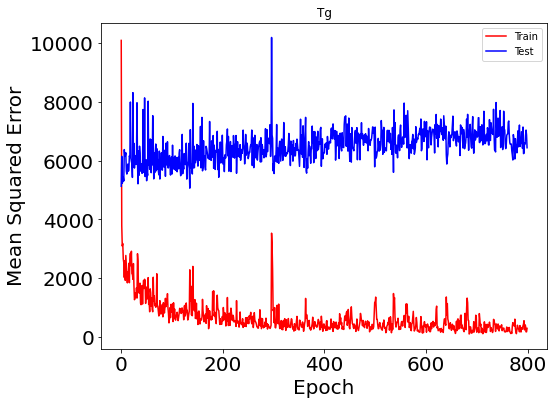

In [59]:

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(history1.history['mean_squared_error'], 'r', label='Train')
ax.plot(history1.history['val_mean_squared_error'], 'b' ,label='Test')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Mean Squared Error', fontsize=20)
ax.legend()
ax.set_title("Tg")
ax.tick_params(labelsize=20)


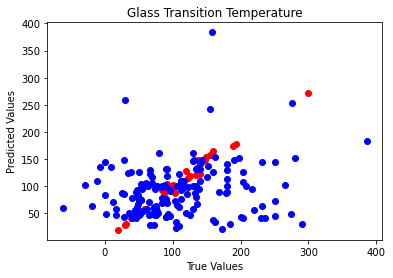

In [60]:
plt.scatter(Y_train,Y_pred_train,color='r',label="Train")
plt.scatter(Y_test,Y_pred_test,color='b',label="Test")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Glass Transition Temperature")
plt.show()

# Melting Temperature

In [61]:
x=data_tm.iloc[:,0:56].values
y=data_tm.iloc[:,58].values

In [62]:
random.seed(1)
X_train,X_test,Y_train,Y_test=train_test_split(x,y,test_size=0.8,random_state=0)


In [63]:
model= Sequential()
model.add(Dense(500,activation='relu',kernel_regularizer=regularizers.L1L2(l1=1e-2, l2=1e-2)))
model.add(Dropout(0.2))
model.add(Dense(400,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(300,activation='relu'))
model.add(Dense(200,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100,activation='relu'))
model.add(Dense(1,activation='linear'))


In [64]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_squared_error'])
history1=model.fit(X_train,Y_train,epochs=800,batch_size=3,verbose=1,
                    validation_data=(X_test, Y_test))

Epoch 1/800
13/13 [==============================] - 0s 15ms/step - loss: 59189.8086 - mean_squared_error: 59175.2422 - val_loss: 21842.2148 - val_mean_squared_error: 21828.6895
Epoch 2/800
13/13 [==============================] - 0s 7ms/step - loss: 16746.8496 - mean_squared_error: 16734.0566 - val_loss: 15251.0146 - val_mean_squared_error: 15239.0947
Epoch 3/800
13/13 [==============================] - 0s 7ms/step - loss: 15915.5889 - mean_squared_error: 15904.2627 - val_loss: 10778.3193 - val_mean_squared_error: 10767.6631
Epoch 4/800
13/13 [==============================] - 0s 7ms/step - loss: 14324.5908 - mean_squared_error: 14314.4111 - val_loss: 9956.9023 - val_mean_squared_error: 9947.2412
Epoch 5/800
13/13 [==============================] - 0s 6ms/step - loss: 12615.7949 - mean_squared_error: 12606.4766 - val_loss: 9449.4082 - val_mean_squared_error: 9440.4580
Epoch 6/800
13/13 [==============================] - 0s 6ms/step - loss: 12539.4092 - mean_squared_error: 12530.6836 -

In [65]:
Y_pred_test=model.predict(X_test)
Y_pred_train=model.predict(X_train)


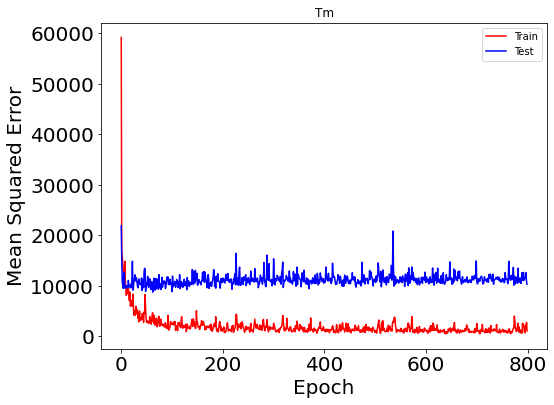

In [67]:

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(history1.history['mean_squared_error'], 'r', label='Train')
ax.plot(history1.history['val_mean_squared_error'], 'b' ,label='Test')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Mean Squared Error', fontsize=20)
ax.legend()
ax.set_title("Tm")
ax.tick_params(labelsize=20)


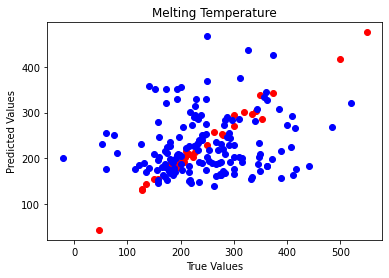

In [68]:
plt.scatter(Y_train,Y_pred_train,color='r',label="Train")
plt.scatter(Y_test,Y_pred_test,color='b',label="Test")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Melting Temperature")
plt.show()